In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

class SoundProperties:
    def __init__(self, pressure=101325):
        self.pressure = pressure
        self.gases = {
            'air': {'gamma': 1.4, 'R': 287.05, 'mass_molar': 0.02897},
            'helium': {'gamma': 1.66, 'R': 2077, 'mass_molar': 0.004},
            'carbon dioxide': {'gamma': 1.3, 'R': 188.9, 'mass_molar': 0.04401},
        }

    def calculate_speed_of_sound(self, T, medium='air'):
        gas = self.gases[medium]
        return np.sqrt(gas['gamma'] * gas['R'] * T)

class TubeSimulation:
    def __init__(self, sound_properties, L=1.0, Nx=100, medium='air', temperature=293.15, sigma=0.05, isplot=False):
        self.L = L  # Longitud del tubo (m)
        self.Nx = Nx  # Número de nodos espaciales
        self.dx = L / Nx  # Paso espacial
        self.temperature = temperature  # Temperatura del aire (en Kelvin)
        self.sound_properties = sound_properties  # Propiedades del sonido
        self.medium = medium
        self.sigma = sigma  # Parámetro para controlar el ancho de la onda
        self.c = self.sound_properties.calculate_speed_of_sound(temperature, medium=medium)
        self.isplot = isplot

    def gaussian_pulse(self, x, x0, amplitude):
        return amplitude * np.exp(-((x - x0) ** 2) / (2 * self.sigma ** 2))

    def simulate_wave_propagation(self, mic_positions, source_position_ratio=0.1, T_total=0.005, amplitude=1.0):
        dt = self.dx / (self.c * 2)  # Paso temporal para estabilidad (condición de CFL)
        Nt = int(T_total / dt)  # Número de pasos temporales
        p_gaussian = np.zeros(self.Nx)  # Presión en cada punto (teórica)
        p_new_gaussian = np.zeros(self.Nx)
        p_old_gaussian = np.zeros(self.Nx)
        p_impulse = np.zeros(self.Nx)
        p_new_impulse = np.zeros(self.Nx)
        p_old_impulse = np.zeros(self.Nx)
        
        # Posición de la fuente (parlante)
        source_position = int(source_position_ratio * self.Nx)
        x = np.linspace(0, self.L, self.Nx)  # Puntos espaciales a lo largo del tubo
        
        # Inicializar la onda gaussiana y el impulso
        p_gaussian = self.gaussian_pulse(x, x[source_position], amplitude)
        p_impulse[source_position] = 1.0
        
        # Indices de las posiciones de los micrófonos
        mic_positions_idx = [int(pos * self.Nx) for pos in mic_positions]
        mic_times_gaussian = {pos: None for pos in mic_positions_idx}
        mic_times_impulse = {pos: None for pos in mic_positions_idx}

        # Para la visualización (gráficas a lo largo del tiempo)
        if self.isplot:
            num_plots = 5  # Número de subplots
            fig, axes = plt.subplots(num_plots, 1, figsize=(10, 12))  # Crear subplots verticales
            time_steps = np.linspace(0, Nt-1, num=num_plots, dtype=int)  # Escoger tiempos de muestreo para gráficos
        
        # Simulación FDTD (Diferencias Finitas en el Dominio del Tiempo)
        for n in range(Nt):
            for i in range(1, self.Nx - 1):
                p_new_gaussian[i] = 2 * p_gaussian[i] - p_old_gaussian[i] + (self.c * dt / self.dx) ** 2 * (p_gaussian[i+1] - 2 * p_gaussian[i] + p_gaussian[i-1])
                p_new_impulse[i] = 2 * p_impulse[i] - p_old_impulse[i] + (self.c * dt / self.dx) ** 2 * (p_impulse[i+1] - 2 * p_impulse[i] + p_impulse[i-1])

            # Detectar cuando la onda llega a cada micrófono (gaussiana e impulso)
            for mic_idx in mic_positions_idx:
                if p_gaussian[mic_idx] > 0.4 and mic_times_gaussian[mic_idx] is None:
                    mic_times_gaussian[mic_idx] = n * dt
                if p_impulse[mic_idx] > 0.4 and mic_times_impulse[mic_idx] is None:
                    mic_times_impulse[mic_idx] = n * dt

            # Actualizar las presiones antiguas y nuevas
            p_old_gaussian = np.copy(p_gaussian)
            p_gaussian = np.copy(p_new_gaussian)
            p_old_impulse = np.copy(p_impulse)
            p_impulse = np.copy(p_new_impulse)

            # Graficar en subplots los resultados en los tiempos seleccionados
            if self.isplot and n in time_steps:
                plot_idx = np.where(time_steps == n)[0][0]  # Índice del subplot correspondiente
                ax = axes[plot_idx]
                ax.plot(p_gaussian, 'r-', label='Gaussiana', alpha=0.7)
                ax.plot(p_impulse, 'b-', label='Impulso', alpha=0.7)
                ax.set_ylim(-1, 1)
                ax.set_title(f"Tiempo = {n * dt:.4f} s")
                ax.set_xlabel("Posición a lo largo del tubo")
                ax.set_ylabel("Presión")
                ax.grid(True)

        # Mostrar la leyenda y ajustar la disposición        
        if self.isplot:
            handles, labels = ax.get_legend_handles_labels()
            fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1))
            plt.tight_layout(rect=[0, 0, 1, 0.97])
            filepath = os.path.join('images', 'perturbacion_air.png')
            plt.savefig(filepath, dpi=300)
            plt.show()

        return mic_times_gaussian, mic_times_impulse, p_gaussian, p_impulse


class DataGenerator:
    def __init__(self, sound_properties, tube_simulation):
        self.sound_properties = sound_properties
        self.tube_simulation = tube_simulation

    def generate_data_position_experiment(self, mic_positions, source_position_ratio=0.1, amplitude=1.0):
        """
        Simula el experimento 1: Medir la velocidad del sonido variando la posición del micrófono (Tabla 1).
        """
        mic_times_gaussian, mic_times_impulse, _, _ = self.tube_simulation.simulate_wave_propagation(
            mic_positions, source_position_ratio, amplitude=amplitude
        )
        distances = [pos * self.tube_simulation.L for pos in mic_positions]

        # Obtener X1 (posición inicial del parlante/micrófono en la misma posición)
        x1 = source_position_ratio * self.tube_simulation.L
        t1_gaussian = mic_times_gaussian[int(source_position_ratio * self.tube_simulation.Nx)]
        t1_impulse = mic_times_impulse[int(source_position_ratio * self.tube_simulation.Nx)]

        # Crear las posiciones X2 (todas las demás posiciones del micrófono)
        data = {
            'X2 (m)': distances,
            't2 (Gaussiana) (s)': [mic_times_gaussian[int(pos * self.tube_simulation.Nx)] for pos in mic_positions],
            't2 (Impulso) (s)': [mic_times_impulse[int(pos * self.tube_simulation.Nx)] for pos in mic_positions],
            'Temperatura (K)': [self.tube_simulation.temperature] * len(mic_positions),
        }

        # Calcular ΔX y Δt para cada posición
        data['ΔX (m)'] = [data['X2 (m)'][i] - x1 for i in range(len(mic_positions))]
        data['Δt (Gaussiana) (s)'] = [data['t2 (Gaussiana) (s)'][i] - t1_gaussian for i in range(len(mic_positions))]
        data['Δt (Impulso) (s)'] = [data['t2 (Impulso) (s)'][i] - t1_impulse for i in range(len(mic_positions))]

        # Calcular c (velocidad del sonido) evitando división por cero
        data['Velocidad del Sonido (Gaussiana) (m/s)'] = [
            data['ΔX (m)'][i] / data['Δt (Gaussiana) (s)'][i] if data['Δt (Gaussiana) (s)'][i] != 0 else np.nan
            for i in range(len(mic_positions))
        ]
        data['Velocidad del Sonido (Impulso) (m/s)'] = [
            data['ΔX (m)'][i] / data['Δt (Impulso) (s)'][i] if data['Δt (Impulso) (s)'][i] != 0 else np.nan
            for i in range(len(mic_positions))
        ]

        # Convertir los datos a un DataFrame
        df = pd.DataFrame(data)

        # Añadir una fila al final del DataFrame con los valores de X1, t1 (Gaussiana) y t1 (Impulso) como un resumen
        summary_row = pd.DataFrame({
            'X2 (m)': ['X1 (m)'],
            't2 (Gaussiana) (s)': [f't1 (Gaussiana) = {t1_gaussian:.5f} s'],
            't2 (Impulso) (s)': [f't1 (Impulso) = {t1_impulse:.5f} s'],
            'Temperatura (K)': [f'Temperatura = {self.tube_simulation.temperature:.2f} K'],
            'ΔX (m)': [f'X1 = {x1:.5f} m'],
            'Δt (Gaussiana) (s)': [None],
            'Δt (Impulso) (s)': [None],
            'Velocidad del Sonido (Gaussiana) (m/s)': [None],
            'Velocidad del Sonido (Impulso) (m/s)': [None]
        })

        # Concatenar el DataFrame con la fila resumen
        df = pd.concat([df, summary_row], ignore_index=True)

        return df

    def generate_data_temperature_experiment(self, T_min, T_max, steps, source_position_ratio=0.1, mic_position_ratio=0.5, amplitude=1.0, plot_results=False, perturbation_strength=0.02):
        """
        Simula el experimento 2: Medir la velocidad del sonido variando la temperatura,
        con la posición del parlante fija y la del micrófono fija. Solo se varía la temperatura.
        
        Parámetros:
            T_min (float): Temperatura mínima en Kelvin.
            T_max (float): Temperatura máxima en Kelvin.
            steps (int): Número de pasos de temperatura.
            source_position_ratio (float): Posición de la fuente como fracción de la longitud del tubo.
            mic_position_ratio (float): Posición del micrófono como fracción de la longitud del tubo.
            amplitude (float): Amplitud de la onda.
            plot_results (bool): Si es True, se grafican los resultados de la velocidad del sonido en función de la temperatura.
            perturbation_strength (float): Magnitud de la perturbación aleatoria (valor entre 0 y 1). Valor predeterminado 0.02.
            
        Retorna:
            pd.DataFrame: DataFrame con la información de temperatura, tiempos y velocidades del sonido.
        """
        # Crear una lista de temperaturas
        temperatures = np.linspace(T_min, T_max, steps)
        mic_position = mic_position_ratio  # Posición fija del micrófono
        source_position = source_position_ratio  # Posición fija del parlante

        # Listas para almacenar los tiempos y velocidades
        times_gaussian = []
        times_impulse = []
        speeds_gaussian = []
        speeds_impulse = []

        for T in temperatures:
            # Actualizar la temperatura en la simulación
            self.tube_simulation.temperature = T
            self.tube_simulation.c = self.sound_properties.calculate_speed_of_sound(T)

            # Simulación de la propagación de la onda para esta temperatura
            mic_times_gaussian, mic_times_impulse, _, _ = self.tube_simulation.simulate_wave_propagation(
                [mic_position], source_position_ratio=source_position_ratio, amplitude=amplitude
            )

            # Calcular la distancia entre el parlante y el micrófono
            distance = (mic_position - source_position) * self.tube_simulation.L

            # Obtener el tiempo de llegada del pulso al micrófono
            time_gaussian = mic_times_gaussian.get(int(mic_position * self.tube_simulation.Nx), None)
            time_impulse = mic_times_impulse.get(int(mic_position * self.tube_simulation.Nx), None)

            if time_gaussian is None or time_impulse is None:
                continue  # Si no se encuentra el tiempo, saltar esta iteración

            # Insertar perturbaciones aleatorias en los tiempos de llegada
            time_gaussian_perturbed = time_gaussian * (1 + np.random.uniform(-perturbation_strength, perturbation_strength))
            time_impulse_perturbed = time_impulse * (1 + np.random.uniform(-perturbation_strength, perturbation_strength))

            # Guardar los tiempos de propagación (con perturbación)
            times_gaussian.append(time_gaussian_perturbed)
            times_impulse.append(time_impulse_perturbed)

            # Calcular la velocidad del sonido para esta temperatura
            speeds_gaussian.append(distance / time_gaussian_perturbed)
            speeds_impulse.append(distance / time_impulse_perturbed)

        # Crear el DataFrame con los resultados
        data = {
            'Temperatura (K)': temperatures,
            'Distancia (m)': [distance] * len(temperatures),
            'Tiempo de propagación (Gaussiana) (s)': times_gaussian,
            'Tiempo de propagación (Impulso) (s)': times_impulse,
            'Velocidad del Sonido (Gaussiana) (m/s)': speeds_gaussian,
            'Velocidad del Sonido (Impulso) (m/s)': speeds_impulse,
        }

        df = pd.DataFrame(data)

        # Graficar los resultados si plot_results es True
        if plot_results:
            plt.figure(figsize=(10, 6))
            plt.plot(df['Temperatura (K)'], df['Velocidad del Sonido (Gaussiana) (m/s)'], 'r-', label='Gaussiana')
            plt.plot(df['Temperatura (K)'], df['Velocidad del Sonido (Impulso) (m/s)'], 'b-', label='Impulso')
            plt.title("Velocidad del Sonido en función de la Temperatura con Perturbaciones")
            plt.xlabel("Temperatura (K)")
            plt.ylabel("Velocidad del Sonido (m/s)")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            os.makedirs('images', exist_ok=True)
            filepath = os.path.join('images', f'sound_vs_time.png')
            plt.savefig(filepath, dpi=300)
            plt.show()

        return df

    
def compare_gases_at_fixed_temperature_subplots(T=300, source_position_ratio=0.1, mic_positions=[0.2], amplitude=1.0):
    """
    Compara la evolución de las ondas en diferentes gases a una temperatura fija en subplots.
    :param T: Temperatura en Kelvin a la cual se realizará la comparación (por defecto, 300 K).
    :param source_position_ratio: Posición de la fuente en el tubo (proporción del largo del tubo).
    :param mic_positions: Lista de posiciones de los micrófonos para observar la onda.
    :param amplitude: Amplitud del pulso.
    """
    # Gases disponibles para la comparación
    gases = ['air', 'helium', 'carbon dioxide']
    
    # Crear subplots
    fig, axes = plt.subplots(len(gases), 1, figsize=(10, 8), sharex=True)  # Subplots para cada gas
    fig.suptitle(f'Comparación de la propagación de ondas en diferentes gases a {T} K', fontsize=16)
    
    # Iterar sobre cada gas y realizar la simulación
    for i, gas in enumerate(gases):
        # Crear una nueva simulación para cada gas
        tube_sim = TubeSimulation(sound_properties, L=1.0, Nx=100, medium=gas, temperature=T, sigma=0.01, isplot=False)

        # Obtener los tiempos de propagación en los micrófonos para cada gas
        mic_times_gaussian, mic_times_impulse, p_gaussian, p_impulse = tube_sim.simulate_wave_propagation(
            mic_positions, source_position_ratio=source_position_ratio, amplitude=amplitude
        )
        # Generar el gráfico para cada gas
        ax = axes[i]
        for mic_idx, mic_pos in enumerate(mic_positions):
            # Graficar la onda gaussiana
            ax.plot(
                mic_times_gaussian[mic_pos*tube_sim.Nx] * np.ones_like(mic_times_gaussian[mic_pos*tube_sim.Nx]), 'r-',
                label='Gaussiana' if mic_idx == 0 else "", alpha=0.7
            )
            # Graficar la onda de impulso
            ax.plot(
                mic_times_impulse[mic_pos*tube_sim.Nx] * np.ones_like(mic_times_impulse[mic_pos*tube_sim.Nx]), 'b-',
                label='Impulso' if mic_idx == 0 else "", alpha=0.7
            )

        ax.set_ylim(-1, 1)
        ax.set_title(f'Gas: {gas.capitalize()}')
        ax.set_ylabel("Presión")
        ax.grid(True)

    # Añadir etiquetas y leyenda
    axes[-1].set_xlabel("Tiempo (s)")
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.95))
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar para la leyenda fuera de los subplots
    plt.show()

def plot_experiment_results(df, x_col, y_col, title, xlabel, ylabel):
    plt.figure(figsize=(8, 6))
    plt.plot(df[x_col], df[y_col], marker='o')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()


def generate_wave_graph(temperature, T_total, L=1.0, Nx=100, source_position_ratio=0.1, mic_positions=[0.2, 0.5, 0.8], amplitude=0.08):
    sound_properties = SoundProperties()
    num_gases = len(sound_properties.gases) 
    fig, axes = plt.subplots(num_gases, 1, figsize=(10, 6 * num_gases))  # Crear subplots verticales

    # Iterar sobre cada gas y realizar la simulación
    for idx, medium in enumerate(sound_properties.gases.keys()):
        # Crear una instancia de TubeSimulation para el medio actual
        simulation = TubeSimulation(sound_properties, L=L, Nx=Nx, medium=medium, temperature=temperature, sigma=0.05, isplot=False)

        # Realizar la simulación de propagación de la onda
        _, _, p_gaussian, p_impulse = simulation.simulate_wave_propagation(
            mic_positions=mic_positions, source_position_ratio=source_position_ratio, T_total=T_total, amplitude=amplitude
        )
        x = np.linspace(0, L, Nx)  # Puntos espaciales a lo largo del tubo

        # Acceder al subplot correspondiente
        ax = axes[idx] if num_gases > 1 else axes  # Para un solo gas, 'axes' es un solo objeto y no lista

        # Crear la gráfica en el subplot
        ax.plot(x, p_gaussian, 'r-', label='Gaussiana', alpha=0.7)
        ax.plot(x, p_impulse, 'b-', label='Impulso', alpha=0.7)
        ax.set_title(f"Presión de Onda en {medium.capitalize()} - Temperatura: {temperature} K, Tiempo total: {T_total} s")
        ax.set_xlabel("Posición a lo largo del tubo (m)")
        ax.set_ylabel("Presión")
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    os.makedirs('images', exist_ok=True)
    filepath = os.path.join('images', f'wave_simulation_subplots_{int(temperature)}K_{int(T_total*1000)}ms.png')
    plt.savefig(filepath, dpi=300)
    plt.show()

    print(f"Gráfica generada y guardada en: {filepath}")


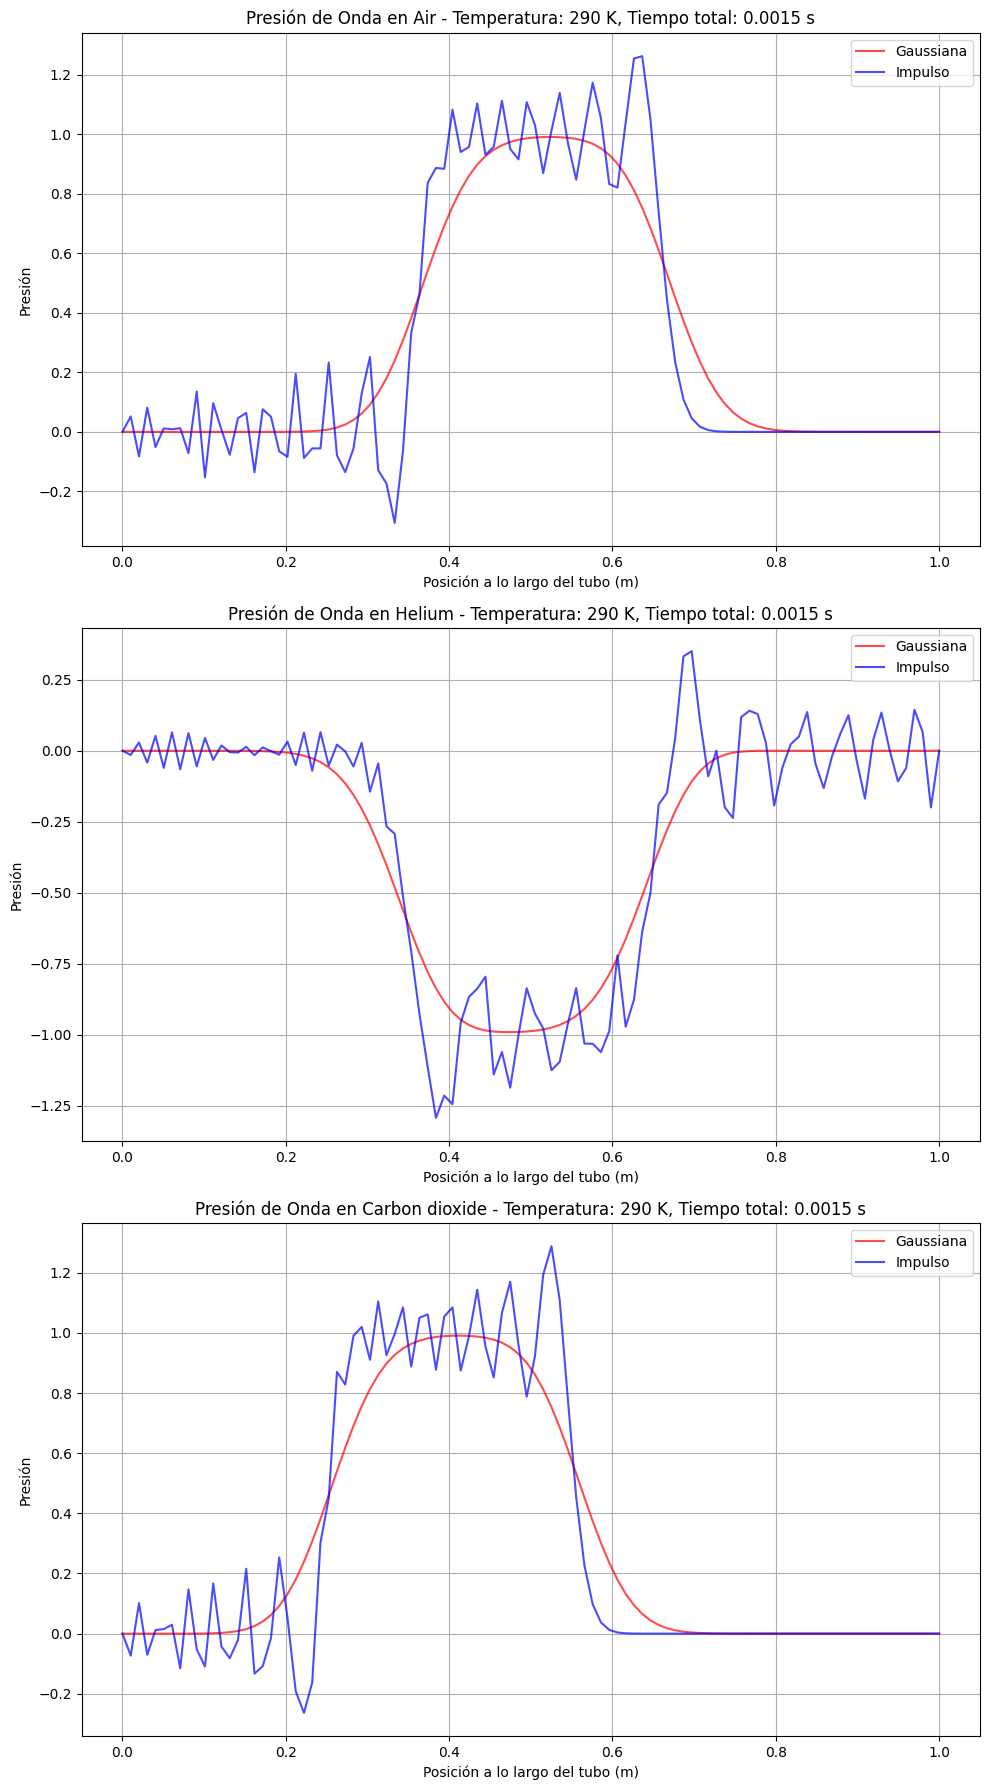

Gráfica generada y guardada en: images/wave_simulation_subplots_290K_1ms.png


In [2]:
generate_wave_graph(temperature=290, T_total=0.0015, L=1.0, Nx=100, source_position_ratio=0.15, mic_positions=[0.2, 0.5, 0.8], amplitude=0.08)


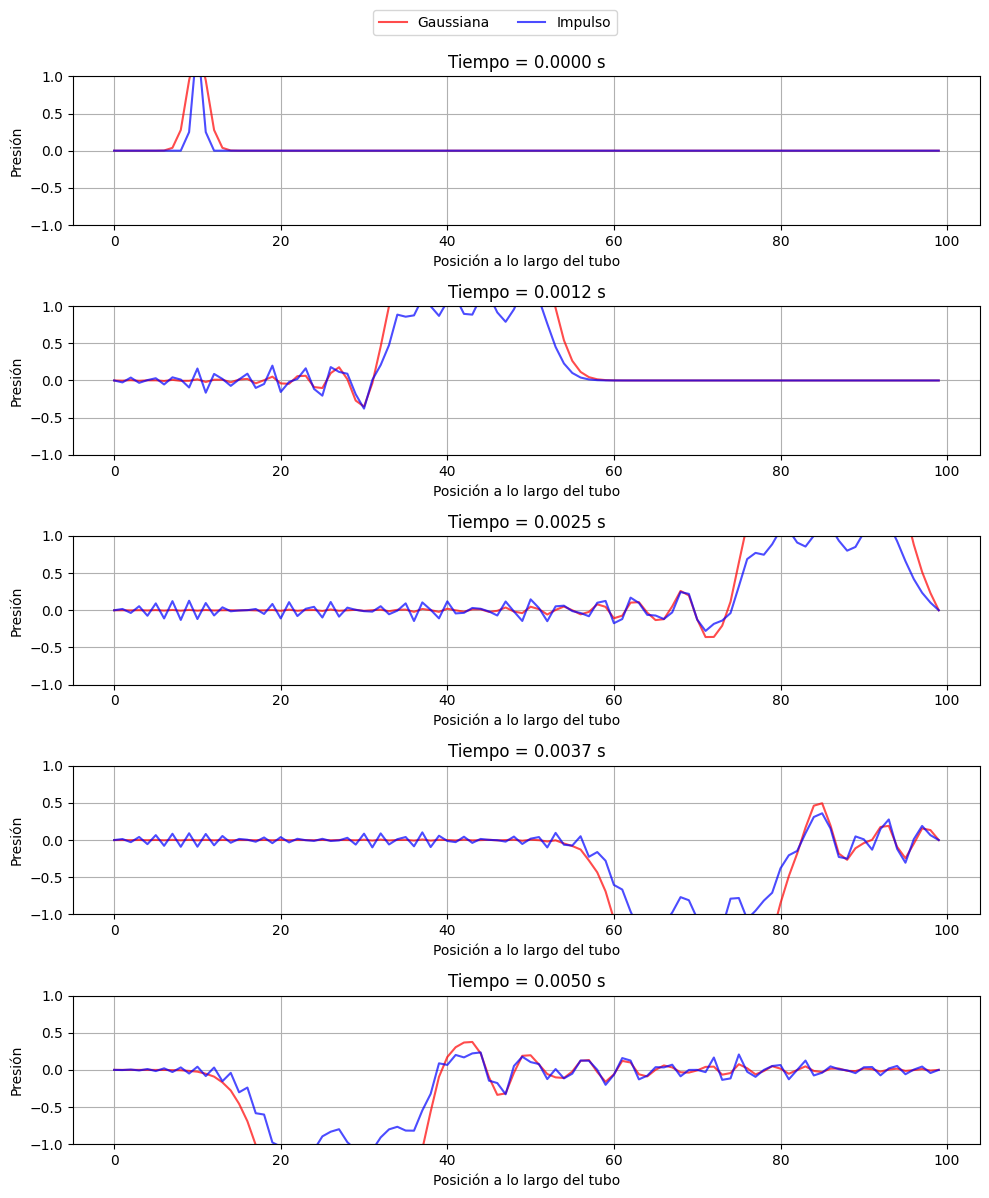

In [135]:
sound_properties = SoundProperties()
tube_sim = TubeSimulation(sound_properties, L=1.0, Nx=100, medium="air", temperature=293, sigma=0.01, isplot=True)
mic_positions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
data_generator = DataGenerator(sound_properties, tube_sim)
position_data = data_generator.generate_data_position_experiment(mic_positions, source_position_ratio=0.1, amplitude=0.8)

In [3]:
sound_properties = SoundProperties()
tube_sim = TubeSimulation(sound_properties, L=1.0, Nx=100, medium="air", temperature=293, sigma=0.01, isplot=False)
mic_positions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
data_generator = DataGenerator(sound_properties, tube_sim)
position_data = data_generator.generate_data_position_experiment(mic_positions, source_position_ratio=0.1, amplitude=0.8)
position_data

,X2 (m),t2 (Gaussiana) (s),t2 (Impulso) (s),Temperatura (K),ΔX (m),Δt (Gaussiana) (s),Δt (Impulso) (s),Velocidad del Sonido (Gaussiana) (m/s),Velocidad del Sonido (Impulso) (m/s)
0,0.1,0.0,0.0,293,0.0,0.0,0.0,NaN,NaN
1,0.2,0.000262,0.000291,293,0.1,0.000262,0.000291,381.271282,343.144153
2,0.3,0.000554,0.000583,293,0.2,0.000554,0.000583,361.204372,343.144153
3,0.4,0.000845,0.000874,293,0.3,0.000845,0.000874,354.97671,343.144153
4,0.5,0.001137,0.001166,293,0.4,0.001137,0.001166,351.942721,343.144153
5,0.6,0.001428,0.001457,293,0.5,0.001428,0.001457,350.147095,343.144153
6,0.7,0.001719,0.001749,293,0.6,0.001719,0.001749,348.960156,343.144153
7,0.8,0.001996,0.00204,293,0.7,0.001996,0.00204,350.658259,343.144153
8,0.9,0.002288,0.002331,293,0.8,0.002288,0.002331,349.701048,343.144153
9,X1 (m),t1 (Gaussiana) = 0.00000 s,t1 (Impulso) = 0.00000 s,Temperatura = 293.00 K,X1 = 0.10000 m,None,None,None,None


In [4]:
temperature_data = data_generator.generate_data_temperature_experiment(
    T_min=280,   # Temperatura mínima en Kelvin
    T_max=310,   # Temperatura máxima en Kelvin
    steps=10,    # Número de pasos de temperatura
    mic_position_ratio=0.6,  # Posición del micrófono (proporción a lo largo del tubo)
    amplitude=0.8  # Amplitud de la onda
)
temperature_data

,Temperatura (K),Distancia (m),Tiempo de propagación (Gaussiana) (s),Tiempo de propagación (Impulso) (s),Velocidad del Sonido (Gaussiana) (m/s),Velocidad del Sonido (Impulso) (m/s)
0,280.000000,0.5,0.001482,0.001490,337.352046,335.464171
1,283.333333,0.5,0.001440,0.001502,347.175182,332.970497
2,286.666667,0.5,0.001458,0.001446,342.919085,345.784247
3,290.000000,0.5,0.001454,0.001459,343.890393,342.702713
4,293.333333,0.5,0.001413,0.001471,353.851162,339.991867
5,296.666667,0.5,0.001411,0.001443,354.282126,346.508188
6,300.000000,0.5,0.001431,0.001416,349.352720,353.184042
7,303.333333,0.5,0.001412,0.001434,354.145247,348.794873
8,306.666667,0.5,0.001395,0.001409,358.297838,354.893663
9,310.000000,0.5,0.001400,0.001419,357.228405,352.441344


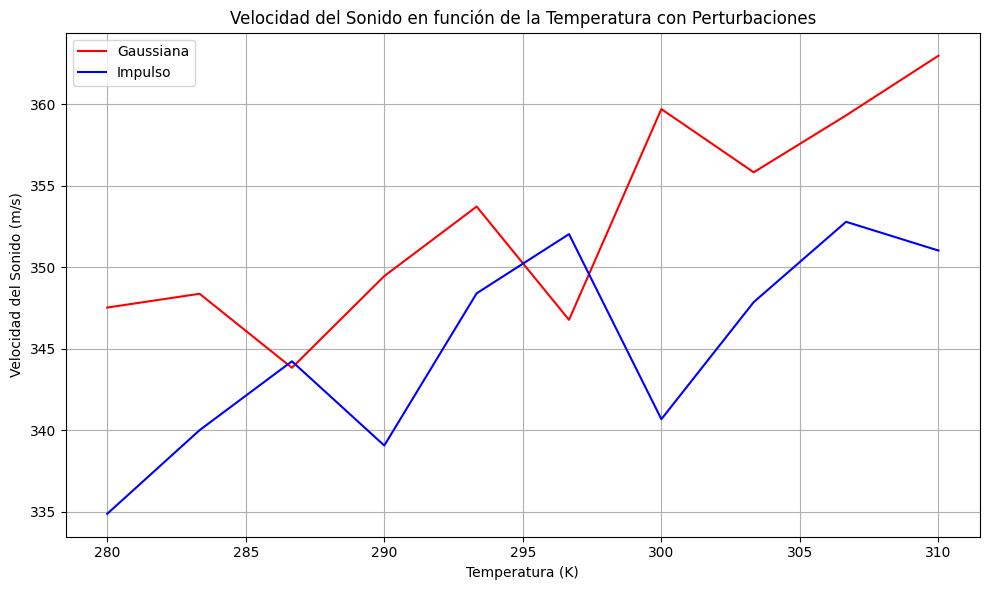

In [5]:
temperature_data = data_generator.generate_data_temperature_experiment(
    T_min=280,   # Temperatura mínima en Kelvin
    T_max=310,   # Temperatura máxima en Kelvin
    steps=10,    # Número de pasos de temperatura
    mic_position_ratio=0.6,  # Posición del micrófono (proporción a lo largo del tubo)
    amplitude=0.8,  # Amplitud de la onda
    plot_results=True
)